In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path

from sklearn.preprocessing import  OneHotEncoder, MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


In [2]:
root_path = Path(os.getcwd()).resolve().parent

In [3]:
sys.path.append(str(root_path))

In [4]:
pd.set_option('display.max_columns',500)

In [5]:
df = pd.read_csv("../data/processed/heart_disease_dataset_new.csv")

In [6]:
data = df.copy()

In [7]:
data

,Edad,Sexo,TipoDolorTorax,PresionArterialReposo,Colesterol,GlucosaEnAyunas,ECGReposo,FreqCardiacaMaxima,AnginaDeEsfuerzo,DescensoST,PendienteST,EnfermedadCardiaca
0,40,M,ATA,140,289.0,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180.0,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283.0,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214.0,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195.0,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1190,42,F,ASY,159,463.0,0,ST,99,N,0.3,Down,1
1191,30,F,ASY,173,356.0,0,Normal,186,Y,3.7,Down,1
1192,34,M,TA,177,432.0,1,LVH,136,N,5.2,Up,0
1193,54,M,NAP,122,540.0,0,ST,113,N,0.5,Down,1


Transformar las varibales categoricas nominales a categoricas ordinales

Tabla con descripcion de cada variable

Separación del conjunto de datos en features y target

In [8]:
X = data.drop(columns='EnfermedadCardiaca')

In [9]:
y = data['EnfermedadCardiaca']

Transformando las variables utilizando onehotencoder para evitar que el modelo interprete cada variable utilizando diferentes pesos

In [10]:
X_ohe = X.copy()

In [11]:
categorical_cols = X_ohe.select_dtypes(include=["object"]).columns

In [12]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_array = encoder.fit_transform(X_ohe[categorical_cols])

In [13]:
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=X_ohe.index)

In [14]:
X_ohe = pd.concat([X_ohe.drop(columns=categorical_cols), encoded_df], axis=1)

Analisis de la escala de cada variable

In [15]:
X_ohe

,Edad,PresionArterialReposo,Colesterol,GlucosaEnAyunas,FreqCardiacaMaxima,DescensoST,Sexo_F,Sexo_M,TipoDolorTorax_ASY,TipoDolorTorax_ATA,TipoDolorTorax_NAP,TipoDolorTorax_TA,ECGReposo_LVH,ECGReposo_Normal,ECGReposo_ST,AnginaDeEsfuerzo_N,AnginaDeEsfuerzo_Y,PendienteST_Down,PendienteST_Flat,PendienteST_Up
0,40,140,289.0,0,172,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,160,180.0,0,156,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,130,283.0,0,98,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,48,138,214.0,0,108,1.5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,54,150,195.0,0,122,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,42,159,463.0,0,99,0.3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1191,30,173,356.0,0,186,3.7,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1192,34,177,432.0,1,136,5.2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1193,54,122,540.0,0,113,0.5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [16]:
X_ohe.describe()

,Edad,PresionArterialReposo,Colesterol,GlucosaEnAyunas,FreqCardiacaMaxima,DescensoST,Sexo_F,Sexo_M,TipoDolorTorax_ASY,TipoDolorTorax_ATA,TipoDolorTorax_NAP,TipoDolorTorax_TA,ECGReposo_LVH,ECGReposo_Normal,ECGReposo_ST,AnginaDeEsfuerzo_N,AnginaDeEsfuerzo_Y,PendienteST_Down,PendienteST_Flat,PendienteST_Up
count,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000
mean,53.339749,134.821757,268.169038,0.229289,136.791632,1.366946,0.278661,0.721339,0.482008,0.202510,0.217573,0.097908,0.222594,0.534728,0.242678,0.582427,0.417573,0.129707,0.457741,0.412552
std,10.781369,22.161790,85.669732,0.420551,28.900353,1.526561,0.448528,0.448528,0.499885,0.402039,0.412768,0.297315,0.416162,0.499001,0.428881,0.493365,0.493365,0.336122,0.498420,0.492500
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,120.000000,215.000000,0.000000,116.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,260.000000,0.000000,138.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,61.000000,146.500000,291.000000,0.000000,159.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Se nota que los datos no están escalados, lo que puede causar problemas durante los estudios realizados en este conjunto de datos. Utilizaremos el metodo MinMaxScaler de la libreria Sklearn para escalar nuestros datos.

In [17]:
X_ohe_scaled = X_ohe.copy()

In [18]:
numerical_cols = X_ohe.select_dtypes(include=['int64', 'float64']).columns

In [19]:
scaler = MinMaxScaler()
X_ohe_scaled[numerical_cols] = scaler.fit_transform(X_ohe[numerical_cols])

In [20]:
X_ohe_scaled

,Edad,PresionArterialReposo,Colesterol,GlucosaEnAyunas,FreqCardiacaMaxima,DescensoST,Sexo_F,Sexo_M,TipoDolorTorax_ASY,TipoDolorTorax_ATA,TipoDolorTorax_NAP,TipoDolorTorax_TA,ECGReposo_LVH,ECGReposo_Normal,ECGReposo_ST,AnginaDeEsfuerzo_N,AnginaDeEsfuerzo_Y,PendienteST_Down,PendienteST_Flat,PendienteST_Up
0,0.244898,0.500000,0.393822,0.0,0.788732,0.295455,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.428571,0.666667,0.183398,0.0,0.676056,0.409091,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.183673,0.416667,0.382239,0.0,0.267606,0.295455,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.408163,0.483333,0.249035,0.0,0.338028,0.465909,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.530612,0.583333,0.212355,0.0,0.436620,0.295455,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,0.285714,0.658333,0.729730,0.0,0.274648,0.329545,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1191,0.040816,0.775000,0.523166,0.0,0.887324,0.715909,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1192,0.122449,0.808333,0.669884,1.0,0.535211,0.886364,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1193,0.530612,0.350000,0.878378,0.0,0.373239,0.352273,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [21]:
X_ohe_scaled.describe()

,Edad,PresionArterialReposo,Colesterol,GlucosaEnAyunas,FreqCardiacaMaxima,DescensoST,Sexo_F,Sexo_M,TipoDolorTorax_ASY,TipoDolorTorax_ATA,TipoDolorTorax_NAP,TipoDolorTorax_TA,ECGReposo_LVH,ECGReposo_Normal,ECGReposo_ST,AnginaDeEsfuerzo_N,AnginaDeEsfuerzo_Y,PendienteST_Down,PendienteST_Flat,PendienteST_Up
count,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000
mean,0.517138,0.456848,0.353608,0.229289,0.540786,0.450789,0.278661,0.721339,0.482008,0.202510,0.217573,0.097908,0.222594,0.534728,0.242678,0.582427,0.417573,0.129707,0.457741,0.412552
std,0.220028,0.184682,0.165386,0.420551,0.203524,0.173473,0.448528,0.448528,0.499885,0.402039,0.412768,0.297315,0.416162,0.499001,0.428881,0.493365,0.493365,0.336122,0.498420,0.492500
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.367347,0.333333,0.250965,0.000000,0.394366,0.295455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.530612,0.416667,0.337838,0.000000,0.549296,0.409091,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.673469,0.554167,0.397683,0.000000,0.697183,0.522727,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Resumen de preprocesamento

* Separacion de los datos en X e y
    * X = Conjunto de todas las variables excepto la columna target
    * y = columna target, variable que identifica se el paciente tiene problema cardiaco o no.
* Tratamiento de la X
    * Transformacción de las variables a traves de la libreria OneHotEncoder
    * Escalar las variables a traves del metodo StandardScaler

Reducción de dimensionalidad utilizando PCA

In [22]:
pca = PCA(n_components=.95)

In [23]:
X_ohe_scaled_pca = pca.fit_transform(X_ohe_scaled)

In [24]:
X_ohe_scaled_pca

array([[-1.14470913,  0.76912551,  0.06162456, ...,  0.01339702,
        -0.1108695 , -0.14983797],
       [-0.53117788, -0.37020319,  1.05211104, ..., -0.10648978,
        -0.09812601, -0.02850603],
       [-0.98824469,  0.0034477 , -0.88847572, ..., -0.06846169,
        -0.12823553, -0.12671563],
       ...,
       [-0.74039629, -0.10844729, -1.05283103, ...,  0.63893875,
         0.91507558, -0.19829294],
       [-0.41801185, -0.29396243, -0.94381094, ..., -1.01889997,
        -0.36217896, -0.04549044],
       [ 0.47788624, -1.40550032,  0.40500946, ..., -0.00229026,
        -0.06353744, -0.6010878 ]])

In [25]:
pca.explained_variance_ratio_

array([0.23901527, 0.14024647, 0.11118607, 0.09808396, 0.08459113,
       0.07500012, 0.06215498, 0.05425318, 0.04976601, 0.03505631,
       0.01536055])

In [26]:
pca.explained_variance_ratio_.cumsum()

array([0.23901527, 0.37926173, 0.49044781, 0.58853177, 0.6731229 ,
       0.74812302, 0.810278  , 0.86453118, 0.91429719, 0.94935351,
       0.96471406])

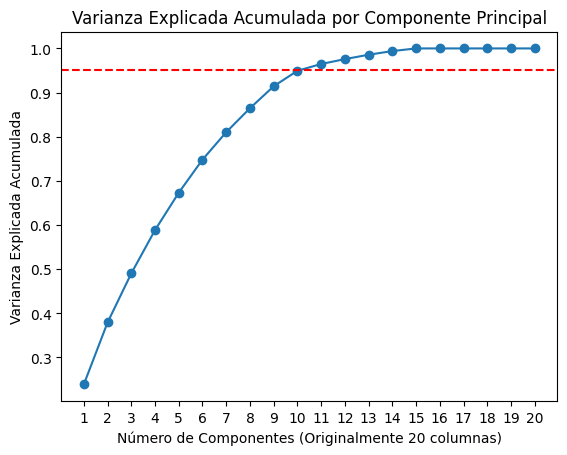

In [27]:
num_columnas_originales = X_ohe_scaled.shape[1]  
pca = PCA() # Create the PCA object.
pca.fit(X_ohe_scaled) # Fit the PCA object.

varianza_explicada = pca.explained_variance_ratio_
varianza_acumulada = pca.explained_variance_ratio_.cumsum()

num_componentes = len(varianza_acumulada)

plt.plot(range(1, num_componentes + 1), varianza_acumulada, marker='o', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='--')

plt.xticks(range(1, num_columnas_originales + 1)) # Usa el número de columnas originales para el eje x
plt.xlabel('Número de Componentes (Originalmente ' + str(num_columnas_originales) + ' columnas)')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada por Componente Principal')

plt.show()

In [28]:
X_ohe_scaled_pca.shape

(1195, 11)

* Varianza explicada:
    * Las diez columnas selecionadas por el PCA retienen el 95.37% de la información relevante.
* Componentes marginales:
    * Los otros componentes aportan información mínima que no sumaria para la mejora del modelo.
* Dimensiones del dataset después de PCA:
    * Si sale de 20 a 11 columnas.


Separacion del conjunto de datos entre datos de entrenamiento y prueba

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=42)

In [30]:
X_ohe_scaled_train, X_ohe_scaled_test, _, _ = train_test_split(X_ohe_scaled, y, test_size=0.2, random_state=42)

In [31]:
X_ohe_scaled_pca_train, X_ohe_scaled_pca_test, _, _ = train_test_split(X_ohe_scaled_pca, y, test_size=0.2, random_state=42)

Training SVM...


Accuracy on Original Train: 0.6872
Accuracy on Original Test: 0.6736
Accuracy on Scaled Train: 0.8598
Accuracy on Scaled Test: 0.8410
Accuracy on Scaled/PCA Train: 0.8515
Accuracy on Scaled/PCA Test: 0.8410
--------------------------------------------------


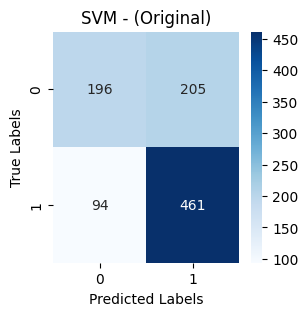

SVM - Classification Report (Original):
              precision    recall  f1-score   support

           0       0.68      0.49      0.57       401
           1       0.69      0.83      0.76       555

    accuracy                           0.69       956
   macro avg       0.68      0.66      0.66       956
weighted avg       0.69      0.69      0.68       956

--------------------------------------------------


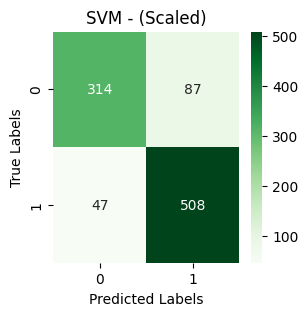

SVM - Classification Report (Scaled):
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       401
           1       0.85      0.92      0.88       555

    accuracy                           0.86       956
   macro avg       0.86      0.85      0.85       956
weighted avg       0.86      0.86      0.86       956

--------------------------------------------------


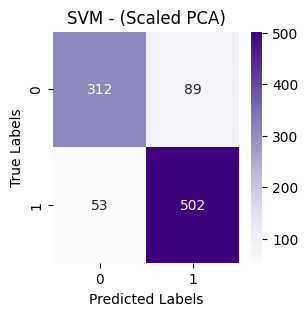

SVM - Classification Report (Scaled PCA):
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       401
           1       0.85      0.90      0.88       555

    accuracy                           0.85       956
   macro avg       0.85      0.84      0.85       956
weighted avg       0.85      0.85      0.85       956

--------------------------------------------------
Training Logistic Regression...


Accuracy on Original Train: 0.8305
Accuracy on Original Test: 0.8536
Accuracy on Scaled Train: 0.8347
Accuracy on Scaled Test: 0.8494
Accuracy on Scaled/PCA Train: 0.8326
Accuracy on Scaled/PCA Test: 0.8410
--------------------------------------------------


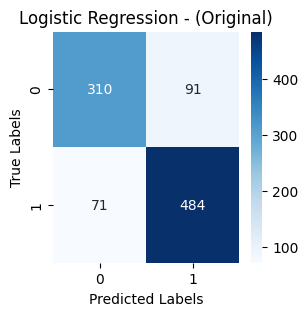

Logistic Regression - Classification Report (Original):
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       401
           1       0.84      0.87      0.86       555

    accuracy                           0.83       956
   macro avg       0.83      0.82      0.82       956
weighted avg       0.83      0.83      0.83       956

--------------------------------------------------


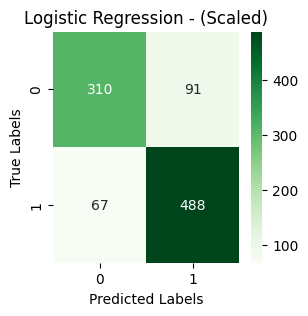

Logistic Regression - Classification Report (Scaled):
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       401
           1       0.84      0.88      0.86       555

    accuracy                           0.83       956
   macro avg       0.83      0.83      0.83       956
weighted avg       0.83      0.83      0.83       956

--------------------------------------------------


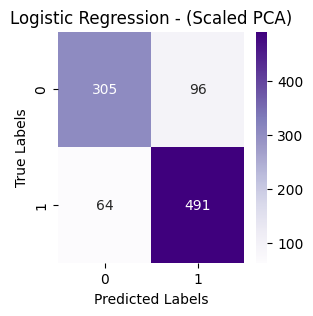

Logistic Regression - Classification Report (Scaled PCA):
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       401
           1       0.84      0.88      0.86       555

    accuracy                           0.83       956
   macro avg       0.83      0.82      0.83       956
weighted avg       0.83      0.83      0.83       956

--------------------------------------------------
Training KNN...


Accuracy on Original Train: 0.7741
Accuracy on Original Test: 0.6653
Accuracy on Scaled Train: 0.8494
Accuracy on Scaled Test: 0.8117
Accuracy on Scaled/PCA Train: 0.8494
Accuracy on Scaled/PCA Test: 0.8159
--------------------------------------------------


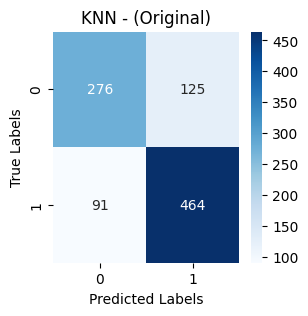

KNN - Classification Report (Original):
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       401
           1       0.79      0.84      0.81       555

    accuracy                           0.77       956
   macro avg       0.77      0.76      0.76       956
weighted avg       0.77      0.77      0.77       956

--------------------------------------------------


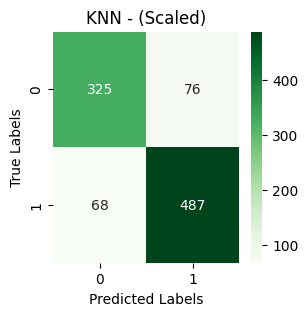

KNN - Classification Report (Scaled):
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       401
           1       0.87      0.88      0.87       555

    accuracy                           0.85       956
   macro avg       0.85      0.84      0.84       956
weighted avg       0.85      0.85      0.85       956

--------------------------------------------------


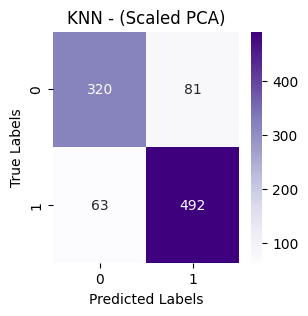

KNN - Classification Report (Scaled PCA):
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       401
           1       0.86      0.89      0.87       555

    accuracy                           0.85       956
   macro avg       0.85      0.84      0.84       956
weighted avg       0.85      0.85      0.85       956

--------------------------------------------------
Training Decision Tree...


Accuracy on Original Train: 1.0000
Accuracy on Original Test: 0.7448
Accuracy on Scaled Train: 1.0000
Accuracy on Scaled Test: 0.7280
Accuracy on Scaled/PCA Train: 1.0000
Accuracy on Scaled/PCA Test: 0.7866
--------------------------------------------------


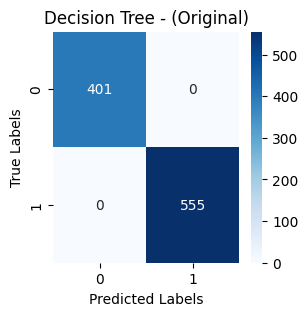

Decision Tree - Classification Report (Original):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       401
           1       1.00      1.00      1.00       555

    accuracy                           1.00       956
   macro avg       1.00      1.00      1.00       956
weighted avg       1.00      1.00      1.00       956

--------------------------------------------------


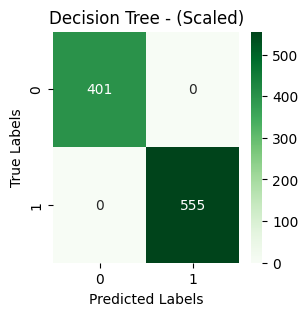

Decision Tree - Classification Report (Scaled):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       401
           1       1.00      1.00      1.00       555

    accuracy                           1.00       956
   macro avg       1.00      1.00      1.00       956
weighted avg       1.00      1.00      1.00       956

--------------------------------------------------


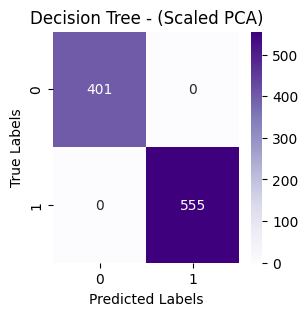

Decision Tree - Classification Report (Scaled PCA):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       401
           1       1.00      1.00      1.00       555

    accuracy                           1.00       956
   macro avg       1.00      1.00      1.00       956
weighted avg       1.00      1.00      1.00       956

--------------------------------------------------
Training Random Forest...


Accuracy on Original Train: 1.0000
Accuracy on Original Test: 0.8452
Accuracy on Scaled Train: 1.0000
Accuracy on Scaled Test: 0.8368
Accuracy on Scaled/PCA Train: 1.0000
Accuracy on Scaled/PCA Test: 0.8159
--------------------------------------------------


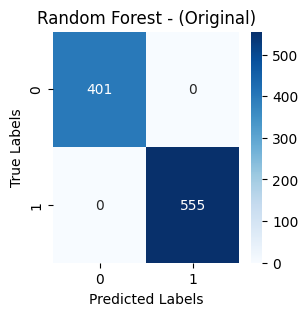

Random Forest - Classification Report (Original):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       401
           1       1.00      1.00      1.00       555

    accuracy                           1.00       956
   macro avg       1.00      1.00      1.00       956
weighted avg       1.00      1.00      1.00       956

--------------------------------------------------


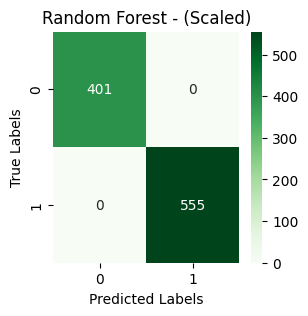

Random Forest - Classification Report (Scaled):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       401
           1       1.00      1.00      1.00       555

    accuracy                           1.00       956
   macro avg       1.00      1.00      1.00       956
weighted avg       1.00      1.00      1.00       956

--------------------------------------------------


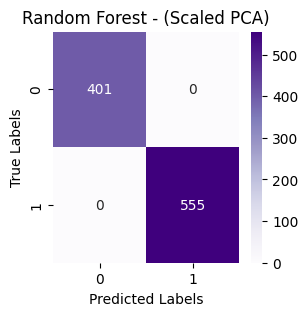

Random Forest - Classification Report (Scaled PCA):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       401
           1       1.00      1.00      1.00       555

    accuracy                           1.00       956
   macro avg       1.00      1.00      1.00       956
weighted avg       1.00      1.00      1.00       956

--------------------------------------------------
Training XGBoost...


Accuracy on Original Train: 1.0000
Accuracy on Original Test: 0.8368
Accuracy on Scaled Train: 1.0000
Accuracy on Scaled Test: 0.8368
Accuracy on Scaled/PCA Train: 1.0000
Accuracy on Scaled/PCA Test: 0.8368
--------------------------------------------------


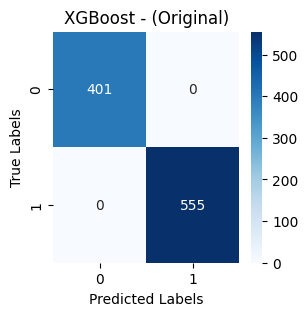

XGBoost - Classification Report (Original):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       401
           1       1.00      1.00      1.00       555

    accuracy                           1.00       956
   macro avg       1.00      1.00      1.00       956
weighted avg       1.00      1.00      1.00       956

--------------------------------------------------


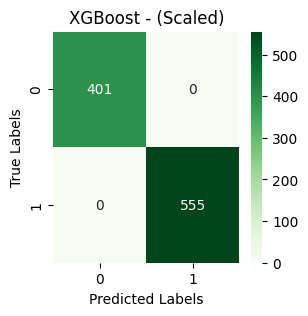

XGBoost - Classification Report (Scaled):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       401
           1       1.00      1.00      1.00       555

    accuracy                           1.00       956
   macro avg       1.00      1.00      1.00       956
weighted avg       1.00      1.00      1.00       956

--------------------------------------------------


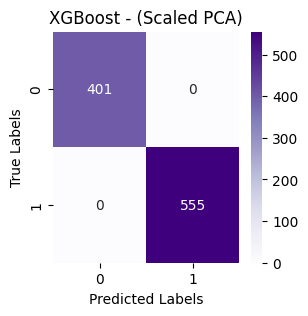

XGBoost - Classification Report (Scaled PCA):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       401
           1       1.00      1.00      1.00       555

    accuracy                           1.00       956
   macro avg       1.00      1.00      1.00       956
weighted avg       1.00      1.00      1.00       956

--------------------------------------------------
Training Gradient Boosting Classifier...


Accuracy on Original Train: 0.9278
Accuracy on Original Test: 0.8285
Accuracy on Scaled Train: 0.9278
Accuracy on Scaled Test: 0.8285
Accuracy on Scaled/PCA Train: 0.9310
Accuracy on Scaled/PCA Test: 0.8452
--------------------------------------------------


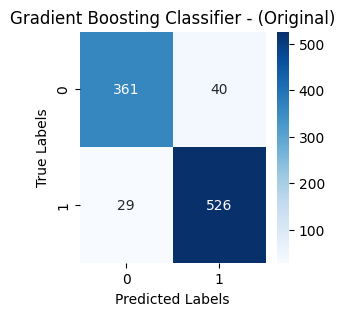

Gradient Boosting Classifier - Classification Report (Original):
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       401
           1       0.93      0.95      0.94       555

    accuracy                           0.93       956
   macro avg       0.93      0.92      0.93       956
weighted avg       0.93      0.93      0.93       956

--------------------------------------------------


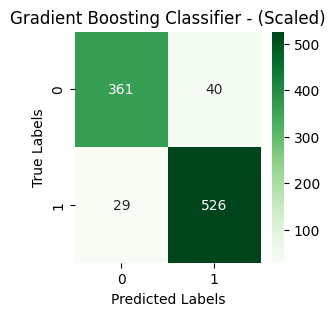

Gradient Boosting Classifier - Classification Report (Scaled):
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       401
           1       0.93      0.95      0.94       555

    accuracy                           0.93       956
   macro avg       0.93      0.92      0.93       956
weighted avg       0.93      0.93      0.93       956

--------------------------------------------------


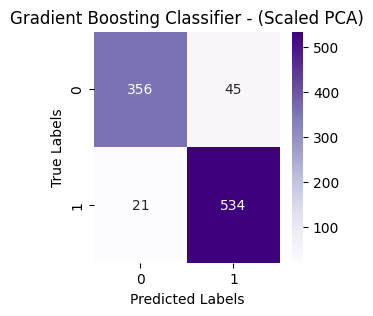

Gradient Boosting Classifier - Classification Report (Scaled PCA):
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       401
           1       0.92      0.96      0.94       555

    accuracy                           0.93       956
   macro avg       0.93      0.92      0.93       956
weighted avg       0.93      0.93      0.93       956

--------------------------------------------------


C:\Users\Felipe\AppData\Local\Temp\ipykernel_5832\1313383935.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.figlegend(loc='upper center', ncol=2)


,Metric,SVM,Logistic Regression,KNN,Decision Tree,Random Forest,XGBoost,Gradient Boosting Classifier
0,Original Train,0.687238,0.830544,0.774059,1.000000,1.000000,1.00000,0.927824
1,Original Test,0.673640,0.853556,0.665272,0.744770,0.845188,0.83682,0.828452
2,Scaled Train,0.859833,0.834728,0.849372,1.000000,1.000000,1.00000,0.927824
3,Scaled Test,0.841004,0.849372,0.811715,0.728033,0.836820,0.83682,0.828452
4,Scaled PCA Train,0.851464,0.832636,0.849372,1.000000,1.000000,1.00000,0.930962
5,Scaled PCA Test,0.841004,0.841004,0.815900,0.786611,0.815900,0.83682,0.845188


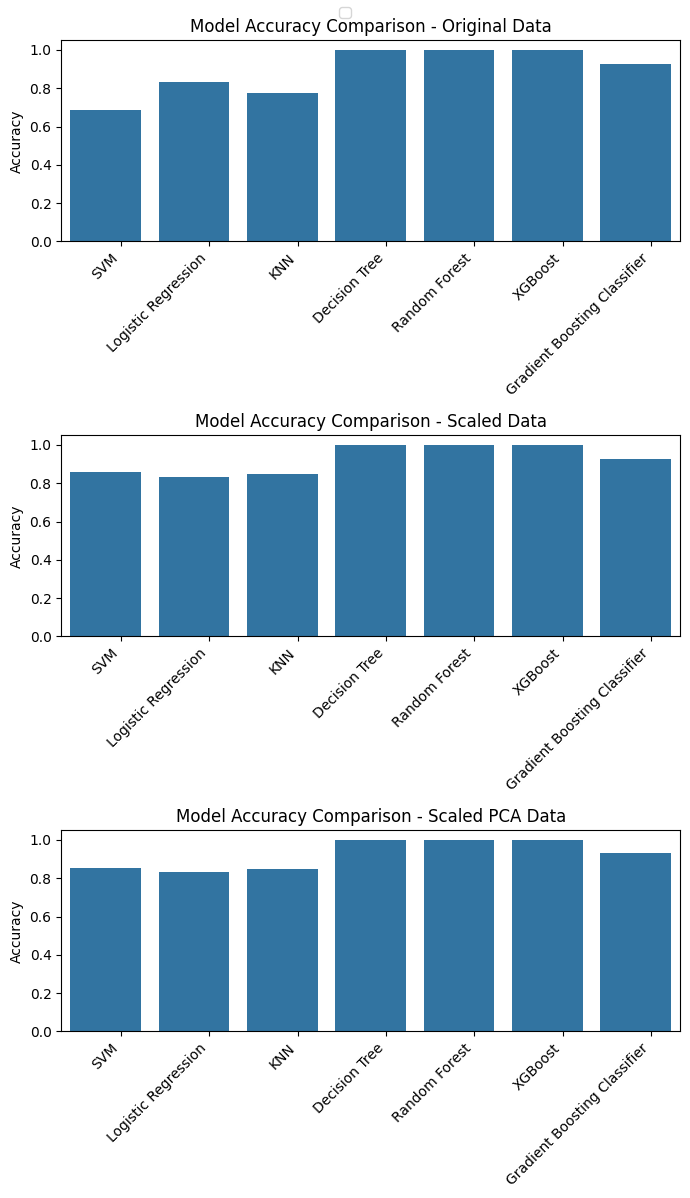

In [32]:
models = {
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier()
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")

    # Original Data
    model.fit(X_train, y_train)
    preds_original_train = model.predict(X_train)
    preds_original_test = model.predict(X_test)
    acc_original_train = accuracy_score(y_train, preds_original_train)
    acc_original_test = accuracy_score(y_test, preds_original_test)

    # Scaled Data
    model.fit(X_ohe_scaled_train, y_train)
    preds_scaled_train = model.predict(X_ohe_scaled_train)
    preds_scaled_test = model.predict(X_ohe_scaled_test)
    acc_scaled_train = accuracy_score(y_train, preds_scaled_train)
    acc_scaled_test = accuracy_score(y_test, preds_scaled_test)

    # Scaled Data with PCA
    model.fit(X_ohe_scaled_pca_train, y_train)
    preds_scaled_pca_train = model.predict(X_ohe_scaled_pca_train)
    preds_scaled_pca_test = model.predict(X_ohe_scaled_pca_test)
    acc_scaled_pca_train = accuracy_score(y_train, preds_scaled_pca_train)
    acc_scaled_pca_test = accuracy_score(y_test, preds_scaled_pca_test)

    print('\n')
    print(f"Accuracy on Original Train: {acc_original_train:.4f}")
    print(f"Accuracy on Original Test: {acc_original_test:.4f}")
    print(f"Accuracy on Scaled Train: {acc_scaled_train:.4f}")
    print(f"Accuracy on Scaled Test: {acc_scaled_test:.4f}")
    print(f"Accuracy on Scaled/PCA Train: {acc_scaled_pca_train:.4f}")
    print(f"Accuracy on Scaled/PCA Test: {acc_scaled_pca_test:.4f}")
    print("-" * 50)

    # Store results
    results[name] = {
        "Original Train": acc_original_train,
        "Original Test": acc_original_test,
        "Scaled Train": acc_scaled_train,
        "Scaled Test": acc_scaled_test,
        "Scaled PCA Train": acc_scaled_pca_train,
        "Scaled PCA Test": acc_scaled_pca_test,
    }

    # Confusion Matrix (Original Data)
    cm_original = confusion_matrix(y_train, preds_original_train)
    plt.figure(figsize=(3,3))
    sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - (Original)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Classification Report (Original Data)
    print(f"{name} - Classification Report (Original):")
    print(classification_report(y_train, preds_original_train))
    print("-" * 50)

    # Confusion Matrix (Scaled Data)
    cm_scaled = confusion_matrix(y_train, preds_scaled_train)
    plt.figure(figsize=(3,3))
    sns.heatmap(cm_scaled, annot=True, fmt='d', cmap='Greens')
    plt.title(f"{name} - (Scaled)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Classification Report (Scaled Data)
    print(f"{name} - Classification Report (Scaled):")
    print(classification_report(y_train, preds_scaled_train))
    print("-" * 50)

    # Confusion Matrix (Scaled PCA Data)
    cm_scaled_pca = confusion_matrix(y_train, preds_scaled_pca_train)
    plt.figure(figsize=(3,3))
    sns.heatmap(cm_scaled_pca, annot=True, fmt='d', cmap='Purples')
    plt.title(f"{name} - (Scaled PCA)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Classification Report (Scaled PCA Data)
    print(f"{name} - Classification Report (Scaled PCA):")
    print(classification_report(y_train, preds_scaled_pca_train))
    print("-" * 50)

# Visualization of comparison between models accuracy
model_names = list(models.keys())

data_transforms = ["Original", "Scaled", "Scaled PCA"]
plt.figure(figsize=(7,12))
plt.figlegend(loc='upper center', ncol=2)
for i, transform in enumerate(data_transforms):
    plt.subplot(3, 1, i + 1)  # 3 rows, 1 column, subplot i+1

    train_accuracies = [results[model][f"{transform} Train"] for model in model_names]

    x = range(len(model_names))
    width = 0.35  # Width of the bars

    sns.barplot(x=x, y=train_accuracies)

    plt.xticks([pos + width / 2 for pos in x], model_names, rotation=45, ha="right")
    plt.ylabel("Accuracy")
    plt.title(f"Model Accuracy Comparison - {transform} Data")
    plt.tight_layout()  # Adjust layout to prevent overlap

    # Create DataFrame
table_data = {
    "Metric": [
        "Original Train",
        "Original Test",
        "Scaled Train",
        "Scaled Test",
        "Scaled PCA Train",
        "Scaled PCA Test",
    ]
}

for model_name in models:
    table_data[model_name] = [results[model_name][metric] for metric in table_data['Metric']]

df_results = pd.DataFrame(table_data)
df_results

In [33]:
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga','lbfgs']
}

param_grid_gbc = {
    'n_estimators':[20,50,100,250,300],
    'learning_rate':[0.01, 0.05, 0.1,0.2,0.5],
    'max_depth':[1,2,3,4,5,None],
}

param_grid_svm = {
    'C': [0.1, 1, 10, 100],  
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  
    'degree': [2, 3, 4]
}

# Initialize the model
lr_model = LogisticRegression(max_iter=10000)
gbc = GradientBoostingClassifier()
svmm = SVC()

# Perform Grid Search
grid_search_lr = GridSearchCV(lr_model, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_lr.fit(X_ohe_scaled_pca_train, y_train)

grid_search_gbc = GridSearchCV(gbc, param_grid_gbc, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_gbc.fit(X_train, y_train)

grid_search_svm = GridSearchCV(svmm, param_grid_svm, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_svm.fit(X_ohe_scaled_pca_train, y_train)


# Best parameters and best score
print("Best Logistic Regression Parameters:", grid_search_lr.best_params_)
print("Best Logistic Regression Accuracy:", grid_search_lr.best_score_)

print("Best SVM Parameters:", grid_search_svm.best_params_)
print("Best SVM Accuracy:", grid_search_svm.best_score_)

print("Best Gradient Boosting Classifier Parameters:", grid_search_gbc.best_params_)
print("Best Gradient Boosting Classifier Accuracy:", grid_search_gbc.best_score_)


c:\Users\Felipe\Desktop\THE-BRIDGE\THEBRIDGE-BOOTCAMP\PROYECTO_ML_HEART_DISEASE\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\Desktop\THE-BRIDGE\THEBRIDGE-BOOTCAMP\PROYECTO_ML_HEART_DISEASE\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\Desktop\THE-BRIDGE\THEBRIDGE-BOOTCAMP\PROYECTO_ML_HEART_DISEASE\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *a

Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Logistic Regression Accuracy: 0.8871855188521854
Best SVM Parameters: {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best SVM Accuracy: 0.8895147925703482
Best Gradient Boosting Classifier Parameters: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50}
Best Gradient Boosting Classifier Accuracy: 0.9068112557001445
